In [530]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer

In [531]:
treino = pd.read_csv('https://raw.githubusercontent.com/ricardorocha86/Topicos-B/main/topicosB-treino.csv')
teste = pd.read_csv('https://raw.githubusercontent.com/ricardorocha86/Topicos-B/main/topicosB-teste.csv')
pd.set_option('display.max_columns', None)
print(treino.head())
print(teste.head())

                                   name     sex      age  sibsp  parch  \
0         Allen, Miss. Elisabeth Walton  female  29.0000      0      0   
1        Allison, Master. Hudson Trevor    male   0.9167      1      2   
2  Allison, Mr. Hudson Joshua Creighton    male  30.0000      1      2   
3                   Anderson, Mr. Harry    male  48.0000      0      0   
4     Andrews, Miss. Kornelia Theodosia  female  63.0000      1      0   

   ticket      fare embarked  pclass  survived  
0   24160  211.3375        S       1         1  
1  113781  151.5500        S       1         1  
2  113781  151.5500        S       1         0  
3   19952   26.5500        S       1         1  
4   13502   77.9583        S       1         1  
                                              name     sex   age  sibsp  \
0                     Allison, Miss. Helen Loraine  female   2.0      1   
1  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female  25.0      1   
2                           Andrews,

**Tratamento dos dados faltantes:** aqui já é possível perceber que o conjunto de dados de treinamento possui variáveis com dados faltantes. São elas: 'age', 'fare', e 'embarked'. Já o conjunto de teste não possui valores faltantes

In [532]:
print(treino.shape)
print(treino.info())
print('*******************************************')
print(teste.shape)
print(teste.info())

(1000, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      1000 non-null   object 
 1   sex       1000 non-null   object 
 2   age       790 non-null    float64
 3   sibsp     1000 non-null   int64  
 4   parch     1000 non-null   int64  
 5   ticket    1000 non-null   object 
 6   fare      999 non-null    float64
 7   embarked  998 non-null    object 
 8   pclass    1000 non-null   int64  
 9   survived  1000 non-null   int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 78.2+ KB
None
*******************************************
(309, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      309 non-null    object 
 1   sex       309 non-null    object 
 2   age       309 non-null    flo

A variável 'age' possui 210 valores nulos, 'embarked' possui 2 e 'fare' possui apenas 1.

In [533]:
print(treino.isnull().sum())

name          0
sex           0
age         210
sibsp         0
parch         0
ticket        0
fare          1
embarked      2
pclass        0
survived      0
dtype: int64


Para resolver o problema, iremos substituir os valores faltantes de 'age' e 'fare' pela mediana, e os valores faltantes da variável embarked vamos substituir pela moda (S).

In [534]:
#imp = KNNImputer(n_neighbors=5)
#treino[['age', 'fare']] = imp.fit_transform(treino[['age', 'fare']])
treino['age'] = treino['age'].fillna(treino['age'].median())
treino['fare'] = treino['fare'].fillna(treino['fare'].median())
treino['embarked'] = treino['embarked'].fillna(treino['embarked'].mode()[0])
print(treino.isnull().any())
print(treino.head())

name        False
sex         False
age         False
sibsp       False
parch       False
ticket      False
fare        False
embarked    False
pclass      False
survived    False
dtype: bool
                                   name     sex      age  sibsp  parch  \
0         Allen, Miss. Elisabeth Walton  female  29.0000      0      0   
1        Allison, Master. Hudson Trevor    male   0.9167      1      2   
2  Allison, Mr. Hudson Joshua Creighton    male  30.0000      1      2   
3                   Anderson, Mr. Harry    male  48.0000      0      0   
4     Andrews, Miss. Kornelia Theodosia  female  63.0000      1      0   

   ticket      fare embarked  pclass  survived  
0   24160  211.3375        S       1         1  
1  113781  151.5500        S       1         1  
2  113781  151.5500        S       1         0  
3   19952   26.5500        S       1         1  
4   13502   77.9583        S       1         1  


**Transformando a variável 'sex' numa varíavel numérica e descartando 'ticket', pois não será útil**

In [535]:
treino['sex'] = treino['sex'].map({'male':1, 'female':0})
teste['sex'] = teste['sex'].map({'male':1, 'female':0})
treino = treino.drop('ticket', axis=1)
teste = teste.drop('ticket', axis=1)

## EDA e Feature Engineering

**Descrição dos nossos dados com algumas medidas**

In [536]:
treino.describe()

,sex,age,sibsp,parch,fare,pclass,survived
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,0.646000,29.327500,0.484000,0.384000,33.768975,2.28600,0.392000
std,0.478448,12.536085,1.015271,0.881658,53.961990,0.84197,0.488441
min,0.000000,0.333300,0.000000,0.000000,0.000000,1.00000,0.000000
25%,0.000000,22.000000,0.000000,0.000000,7.895800,1.00000,0.000000
50%,1.000000,28.000000,0.000000,0.000000,14.454200,3.00000,0.000000
75%,1.000000,35.000000,1.000000,0.000000,31.275000,3.00000,1.000000
max,1.000000,70.500000,8.000000,9.000000,512.329200,3.00000,1.000000


No histograma abaixo está a distribuição de idade dos tripulantes. Também vemos abaixo que a idade média daqueles que sobreviveram foi aproximadamente 29.95, equanto a dos que não sobreviveram foi aproximadamente 30.15.

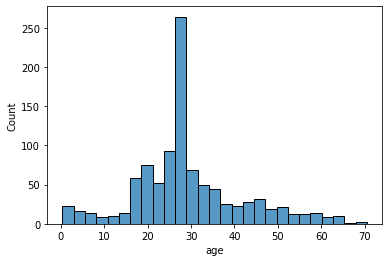

Idade média dos que sobreviveram:  28.675807908163264
Idade média dos que não sobreviveram:  29.74766990131579 

Tarifa média dos que sobreviveram:  50.52083392857144
Tarifa média dos que não sobreviveram:  22.968434210526272


In [537]:
sns.histplot(treino['age'])
plt.show()
print('Idade média dos que sobreviveram: ', (treino.loc[treino['survived']==1, 'age']).mean())
print('Idade média dos que não sobreviveram: ', (treino.loc[treino['survived']==0, 'age']).mean(), '\n')

print('Tarifa média dos que sobreviveram: ', (treino.loc[treino['survived']==1, 'fare']).mean())
print('Tarifa média dos que não sobreviveram: ', (treino.loc[treino['survived']==0, 'fare']).mean())

Np gráfico a seguir vemos que muito mais homens (1) do que mulheres (0) morreram.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


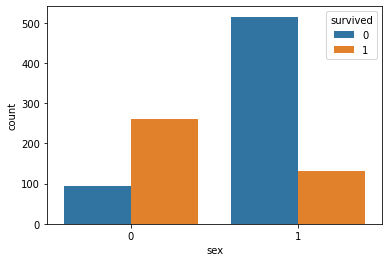

In [538]:
sns.countplot(treino['sex'], hue=treino['survived'])
plt.show()

O gráfico abaixo nos mostra que a minoria das pessoas que estavam na classe 1 sobreviveu, enquanto a maioria das que estavam nas outras duas classes morreu.

        survived
pclass          
1       0.630952
2       0.438095
3       0.262082


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


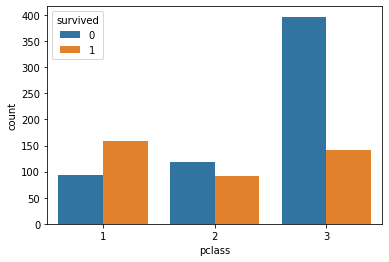

In [539]:
sns.countplot(treino['pclass'], hue=treino['survived'])
print(treino[ ['pclass', 'survived'] ].groupby(['pclass']).mean())

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


       survived
sibsp          
0      0.358491
1      0.521186
2      0.468750
3      0.312500
4      0.117647
5      0.000000
8      0.000000


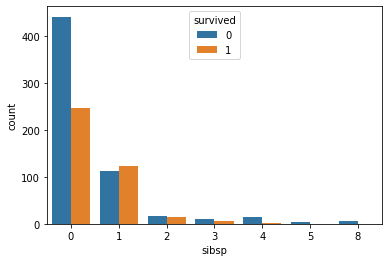

In [540]:
sns.countplot(treino['sibsp'], hue=treino['survived'])
print((treino[ ['sibsp', 'survived'] ].groupby('sibsp')).mean())

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


       survived
parch          
0      0.345502
1      0.601504
2      0.518987
3      0.625000
4      0.200000
5      0.000000
6      0.000000
9      0.000000


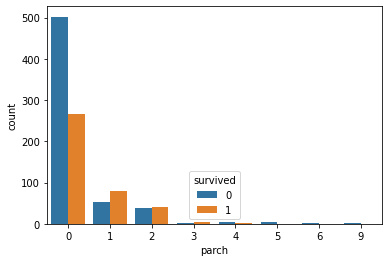

In [541]:
sns.countplot(treino['parch'], hue=treino['survived'])
print((treino[ ['parch', 'survived'] ].groupby('parch')).mean())

          survived
embarked          
C         0.579909
Q         0.333333
S         0.340116


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


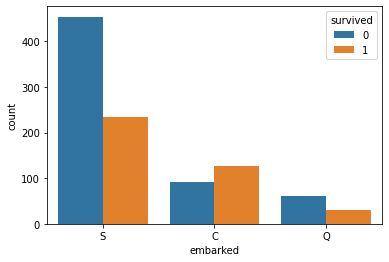

In [542]:
sns.countplot(treino['embarked'], hue=treino['survived'])
print((treino[ ['embarked', 'survived'] ].groupby('embarked')).mean())

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


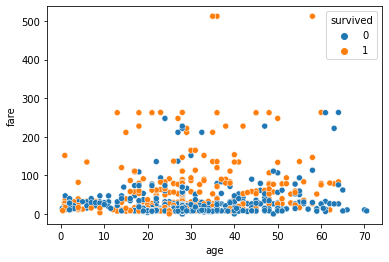

In [543]:
sns.scatterplot(treino['age'], treino['fare'], hue=treino['survived'])
plt.show()

**Catagorizando as variáveis 'age' e 'fare' de acordo com seus respectivos quartis.**

In [544]:
qid = treino['age'].quantile([0.25,0.5,0.75])
qta = treino['fare'].quantile([0.25,0.5,0.75])
print(qid)
print(qta)

0.25    22.0
0.50    28.0
0.75    35.0
Name: age, dtype: float64
0.25     7.8958
0.50    14.4542
0.75    31.2750
Name: fare, dtype: float64


In [545]:
def CatAge(x):
  if x>=0 and x<22:
    return 0
  elif x>=22 and x<28:
    return 1
  elif x>=28 and x<35:
    return 2
  else:
    return 3

def CatFare(x):
  if x>=0 and x<7.9:
    return 0
  elif x>=7.9 and x<14.45:
    return 1
  elif x>=14.45 and x<31.28:
    return 2
  else:
    return 3

treino['CatAge'] = treino['age'].apply(CatAge)
treino['CatFare'] = treino['fare'].apply(CatFare)

teste['CatAge'] = teste['age'].apply(CatAge)
teste['CatFare'] = teste['fare'].apply(CatFare)

**Dummificando variáveis categóricas e padronizando as contínuas**

In [546]:
treino = pd.get_dummies(treino, columns = ['embarked', 'pclass'], drop_first = True)
teste = pd.get_dummies(teste, columns = ['embarked', 'pclass'], drop_first = True)

In [547]:
sc = StandardScaler()
l = ['age', 'fare']
treino[l] = sc.fit_transform(treino[l])
teste[l] = sc.transform(teste[l])

**Criando a variável 'isalone' que identifica se o tripulante estava (1) ou não (0) sozinho**

In [548]:
treino['isalone'] = 1
treino.loc[(treino['sibsp'] != 0) | (treino['parch'] != 0), 'isalone']=0

teste['isalone'] = 1
teste.loc[(teste['sibsp'] != 0) | (teste['parch'] != 0), 'isalone']=0

Criando a variável 'familysize', que mostra o tamanho da família de cada tripulante, ou seja, quantas pessoas estavam a bordo com ele. Essa variável irá substituir 'sibsp' e 'parch', ou seja, iremos descartá-las. A partir do gráfico e medidas abaixo, vemos que muitas pessoas que estavam sozinhas não sobreviveram, mais especificamente, aproximadamente 70.5% das pessoas que estavam sozinha morreram.

In [549]:
print((treino[ ['isalone', 'survived'] ].groupby('isalone')).mean())

         survived
isalone          
0        0.512755
1        0.314145


            survived
familysize          
0           0.314145
1           0.551136
2           0.580645
3           0.689655
4           0.300000
5           0.222222
6           0.166667
7           0.000000
10          0.000000 

0     608
1     176
2     124
3      29
4      20
5      18
6      12
10      8
7       5
Name: familysize, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


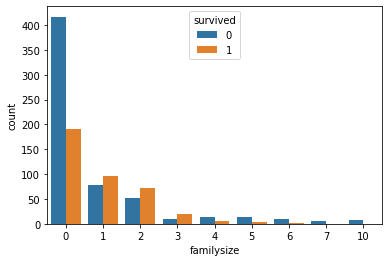

In [550]:
treino['familysize'] = treino['sibsp']+treino['parch']
teste['familysize'] = teste['sibsp']+teste['parch']
print((treino[ ['familysize', 'survived'] ].groupby('familysize')).mean(), '\n')

treino = treino.drop(['sibsp', 'parch'], axis=1)
teste = teste.drop(['sibsp', 'parch'], axis=1)

sns.countplot(treino['familysize'], hue=treino['survived'])
print(treino['familysize'].value_counts())


In [551]:
fm = []
for i in treino['familysize']:
  if i==0:
    fm.append('zero')
  elif i==1:
    fm.append('um')
  elif i==2:
    fm.append('dois')
  else:
    fm.append('três+')
treino['familysize'] = fm

fm=[]
for i in teste['familysize']:
  if i==0:
    fm.append('zero')
  elif i==1:
    fm.append('um')
  elif i==2:
    fm.append('dois')
  else:
    fm.append('três+')
teste['familysize'] = fm

Testando rapidamente os modelos. Vamos testar 4 possíveis formatos:


1.   Com ambas variáveis 'isalone' + 'familysize' e 'age' e 'fare contínuas
2.   Com ambas variáveis 'isalone' + 'familysize' e 'age' e 'fare categorizadas
3.   Apenas com 'isalone' e 'age' e 'fare contínuas
4.   Apenas com 'isalone' e 'age' e 'fare categorizadas

É possível perceber que o modelo Decision Tree melhorou nos casos em que as variáveis 'age' e 'fare' foram categorizadas. 
A menor acurácia para o modelo Random Forest foi 0.7823 (caso 2).
O modelo de regressão logística foi melhor no caso 1 e caiu nos outros 3 casos.
O KNN aparentemente se mostrou o pior modelo, apesar de ainda não termos encontrado o melhor valor para K. O Bagging Classifier se manteve entre 0.7761 e 0.7796.









In [552]:
metrica='accuracy'
modelos = [LogisticRegression(), KNeighborsClassifier(), BaggingClassifier(), DecisionTreeClassifier(), RandomForestClassifier()]
l = ['LR', 'KNN', 'BAG', 'DT', 'RF']

In [553]:
#1
xtreino = treino.drop(['name', 'survived', 'CatAge', 'CatFare'], axis=1)
ytreino = treino['survived']
xtreino = pd.get_dummies(xtreino, columns=['familysize'], drop_first=True)
kf = RepeatedKFold(n_splits=10, n_repeats=10)
accs = {}
for i in range(5):
  ac = cross_val_score(modelos[i], xtreino, ytreino, cv=kf, scoring=metrica)
  accs[l[i]]=ac.mean()
print(accs)

{'LR': 0.7863000000000001, 'KNN': 0.7665999999999998, 'BAG': 0.7757999999999998, 'DT': 0.7538999999999999, 'RF': 0.7871000000000001}


In [554]:
#2
xtreino = treino.drop(['name', 'survived', 'age', 'fare'], axis=1)
xtreino = pd.get_dummies(xtreino, columns=['CatAge', 'CatFare', 'familysize'], drop_first=True)#dummificando 'CatAge' e 'CatFare'
ytreino = treino['survived']
kf = RepeatedKFold(n_splits=10, n_repeats=10)
accs = {}
for i in range(5):
  ac = cross_val_score(modelos[i], xtreino, ytreino, cv=kf, scoring=metrica)
  accs[l[i]]=ac.mean()
print(accs)

{'LR': 0.7854000000000001, 'KNN': 0.7671000000000001, 'BAG': 0.7761, 'DT': 0.7879, 'RF': 0.7824}


In [555]:
#3
xtreino = treino.drop(['name', 'familysize', 'survived', 'CatAge', 'CatFare'], axis=1)
ytreino = treino['survived']
kf = RepeatedKFold(n_splits=10, n_repeats=10)
accs = {}
for i in range(5):
  ac = cross_val_score(modelos[i], xtreino, ytreino, cv=kf, scoring=metrica)
  accs[l[i]]=ac.mean()
print(accs)

{'LR': 0.7801, 'KNN': 0.7745000000000001, 'BAG': 0.7779, 'DT': 0.7576999999999999, 'RF': 0.7884}


In [556]:
#4
xtreino = treino.drop(['name', 'familysize', 'survived', 'age', 'fare'], axis=1)
xtreino = pd.get_dummies(xtreino, columns=['CatAge', 'CatFare'], drop_first=True)#dummificando 'CatAge' e 'CatFare'
ytreino = treino['survived']
kf = RepeatedKFold(n_splits=10, n_repeats=10)
accs = {}
for i in range(5):
  ac = cross_val_score(modelos[i], xtreino, ytreino, cv=kf, scoring=metrica)
  accs[l[i]]=ac.mean()
print(accs)

{'LR': 0.775, 'KNN': 0.7630000000000001, 'BAG': 0.7787999999999999, 'DT': 0.7875999999999999, 'RF': 0.7837000000000001}


Vemos que os tripulantes possuíam títulos em seus nomes, podemos fazer uso desses títulos. Vamos extraí-los e criar uma variável 'title' com os títulos dos tripulantes

In [557]:
#EXEMPLO
(treino['name'][0].split(', ')[1]).split('.')[0]

'Miss'

In [558]:
titles = []
for i in treino['name']:
  titles.append((i.split(', ')[1]).split('.')[0])
treino['title'] = titles

titles=[]
for i in teste['name']:
  titles.append((i.split(', ')[1]).split('.')[0])
teste['title'] = titles


In [559]:
#tabela de frequencia dos titulos
print(treino['title'].value_counts())

Mr              580
Miss            197
Mrs             151
Master           48
Dr                6
Rev               5
Col               4
Mlle              2
the Countess      1
Sir               1
Mme               1
Major             1
Don               1
Ms                1
Lady              1
Name: title, dtype: int64


Vamos agrupar os titulos que não são 'Mr', 'Miss', 'Mrs', 'Master' em uma classe chamada 'Outros', pois aparecem muito pouco

In [560]:

titles = []
for i in treino['title']:
  if i in ['Mr', 'Miss', 'Mrs', 'Master']:
    titles.append(i)
  else:
    titles.append('Outros')
treino['title'] = titles

titles = []
for i in teste['title']:
  if i in ['Mr', 'Miss', 'Mrs', 'Master']:
    titles.append(i)
  else:
    titles.append('Outros')
teste['title'] = titles


No gráfico e medidas abaixo vemos que muito dos que possuíam título de 'Mr' morreram (aproximadamente 82.4%), enquanto  para os que possuíam outros títulos (com exceção da classe 'Outros'), a maioria sobreviveu ou o número de mortos e sobreviventes foi igual.

        survived
title           
Master  0.500000
Miss    0.695431
Mr      0.175862
Mrs     0.781457
Outros  0.458333


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


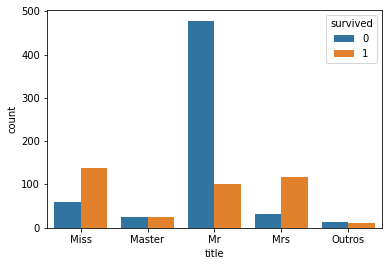

In [561]:
sns.countplot(treino['title'], hue=treino['survived'])
print((treino[['title', 'survived']].groupby('title').mean()))

Agora vamos dummificar 'title' e descartar 'name', pois não será mais útil.

In [562]:
treino = pd.get_dummies(treino, columns=['title'], drop_first=True)
teste = pd.get_dummies(teste, columns=['title'], drop_first=True)
treino = treino.drop('name', axis=1)
teste = teste.drop('name', axis=1)

Repetindo os testes para os mesmos 4 casos anteriores, agora com a feature 'title'.

In [563]:
#1
xtreino = treino.drop(['survived', 'CatAge', 'CatFare'], axis=1)
ytreino = treino['survived']
xtreino = pd.get_dummies(xtreino, columns=['familysize'], drop_first=True)
kf = RepeatedKFold(n_splits=10, n_repeats=10)
accs = {}
for i in range(5):
  ac = cross_val_score(modelos[i], xtreino, ytreino, cv=kf, scoring=metrica)
  accs[l[i]]=ac.mean()
print(accs)

{'LR': 0.8010000000000003, 'KNN': 0.7849, 'BAG': 0.787, 'DT': 0.7497999999999999, 'RF': 0.7887}


In [564]:
#2
xtreino = treino.drop(['survived', 'age', 'fare'], axis=1)
xtreino = pd.get_dummies(xtreino, columns=['CatAge', 'CatFare', 'familysize'], drop_first=True)#dummificando 'CatAge' e 'CatFare'
ytreino = treino['survived']
kf = RepeatedKFold(n_splits=10, n_repeats=10)
accs = {}
for i in range(5):
  ac = cross_val_score(modelos[i], xtreino, ytreino, cv=kf, scoring=metrica)
  accs[l[i]]=ac.mean()
print(accs)

{'LR': 0.8030000000000002, 'KNN': 0.7785, 'BAG': 0.7800999999999999, 'DT': 0.7826000000000001, 'RF': 0.7854000000000001}


In [565]:
#3
xtreino = treino.drop(['familysize', 'survived', 'CatAge', 'CatFare'], axis=1)
ytreino = treino['survived']
kf = RepeatedKFold(n_splits=10, n_repeats=10)
accs = {}
for i in range(5):
  ac = cross_val_score(modelos[i], xtreino, ytreino, cv=kf, scoring=metrica)
  accs[l[i]]=ac.mean()
print(accs)

{'LR': 0.7903000000000001, 'KNN': 0.7807, 'BAG': 0.7876000000000001, 'DT': 0.7592000000000002, 'RF': 0.7985999999999999}


In [566]:
#4
xtreino = treino.drop(['familysize', 'survived', 'age', 'fare'], axis=1)
xtreino = pd.get_dummies(xtreino, columns=['CatAge', 'CatFare'], drop_first=True)#dummificando 'CatAge' e 'CatFare'
ytreino = treino['survived']
kf = RepeatedKFold(n_splits=10, n_repeats=10)
accs = {}
for i in range(5):
  ac = cross_val_score(modelos[i], xtreino, ytreino, cv=kf, scoring=metrica)
  accs[l[i]]=ac.mean()
print(accs)

{'LR': 0.7906, 'KNN': 0.7702999999999999, 'BAG': 0.7807, 'DT': 0.7858999999999999, 'RF': 0.7888000000000001}


#Escolhendo o melhor modelo

Aqui vamos testar os modelos para encontrar o melhor. Também iremos encontrar o os melhores parâmetros quando for necessário. Ou seja, melhor K para KNN e melhor 'max_depth' para Decision Tree e Random Forest

**1º CENÁRIO:** variáveis 'age' e 'fare' contínuas, com a variável 'familysize'.
Nesse cenário o melhor modelo foi Random Forest com uma acurácia de 0.812.

In [567]:
xtreino = treino.drop(['survived', 'CatAge', 'CatFare'], axis=1)
ytreino = treino['survived']
xteste = teste.drop(['CatAge', 'CatFare'], axis=1)
xtreino = pd.get_dummies(xtreino, columns=['familysize'], drop_first=True)#dummificando 'familysize'
xteste = pd.get_dummies(xteste, columns=['familysize'], drop_first=True)#dummificando 'familysize'
kf = RepeatedKFold(n_splits=10, n_repeats=10)

### Regressão Logística

In [568]:
lr = LogisticRegression()
acc_lr = cross_val_score(lr, xtreino, ytreino, cv=kf, scoring=metrica)
print('Acurácia regressão logística: {}'.format(acc_lr.mean()))

Acurácia regressão logística: 0.8003999999999999


### KNN

In [569]:
knn = KNeighborsClassifier()
acc = cross_val_score(knn, xtreino, ytreino, cv=kf, scoring=metrica)
print('Acurácia no KNN: {:.2f}'.format(acc.mean()))

Acurácia no KNN: 0.78


In [570]:
#Encontrando o melhor valor para K
ks = np.arange(1, 20, 2)
parametros = {'n_neighbors':ks}
clf = GridSearchCV(KNeighborsClassifier(), param_grid=parametros, scoring=metrica, cv=kf)
clf.fit(xtreino, ytreino)
accs = clf.cv_results_['mean_test_score']
print('Melhor K foi {} e sua acurácia foi {}'.format(clf.best_params_.get('n_neighbors'), max(accs)))

Melhor K foi 19 e sua acurácia foi 0.7896999999999998


### Bagging Classifier

In [571]:
bg = BaggingClassifier()
acc = cross_val_score(bg, xtreino, ytreino, cv=kf, scoring=metrica)
print(acc.mean())

0.7841000000000001


### Decision Tree

In [572]:
dt = DecisionTreeClassifier()
acc = cross_val_score(dt, xtreino, ytreino, cv=kf, scoring=metrica)
print('Acurácia na DT: {:.2f}'.format(acc.mean()))

Acurácia na DT: 0.75


In [573]:
#Encontrando o melhor max_depth
dps = np.arange(2, 10, 2)
parametros = {'max_depth':dps}
clf = GridSearchCV(DecisionTreeClassifier(), param_grid=parametros, scoring=metrica, cv=kf)
clf.fit(xtreino, ytreino)
accs = clf.cv_results_['mean_test_score']
print('Melhor max_depth foi {} e sua acurácia foi {}'.format(clf.best_params_.get('max_depth'), max(accs)))

Melhor max_depth foi 4 e sua acurácia foi 0.7970999999999999


### Random Forest

In [574]:
rf = RandomForestClassifier()
acc = cross_val_score(rf, xtreino, ytreino, cv=kf, scoring=metrica)
print('Acurácia na RF: {:.2f}'.format(acc.mean()))

Acurácia na RF: 0.79


In [575]:
#Encontrando o melhor max_depth
dps = np.arange(2, 13, 2)
parametros = {'max_depth':dps}
clf = GridSearchCV(RandomForestClassifier(), param_grid=parametros, scoring=metrica, cv=kf)
clf.fit(xtreino, ytreino)
accs = clf.cv_results_['mean_test_score']
melhor_md_rf1 = clf.best_params_.get('max_depth')
print(accs)
print('Melhor max_depth foi {} e sua acurácia foi {}'.format(melhor_md_rf1, max(accs)))

[0.7786 0.8051 0.8065 0.812  0.8078 0.8002]
Melhor max_depth foi 8 e sua acurácia foi 0.812


**2º CENÁRIO:** variáveis 'age' e 'fare' contínuas, sem 'familysize'.
Nesse cenário o melhor modelo foi Random Forest com uma acurácia de 0.8138

In [576]:
xtreino = treino.drop(['familysize', 'survived', 'CatAge', 'CatFare'], axis=1)
ytreino = treino['survived']
xteste = teste.drop(['familysize', 'CatAge', 'CatFare'], axis=1)
kf = RepeatedKFold(n_splits=10, n_repeats=10)

### Regressão Logística

In [577]:
lr = LogisticRegression()
acc_lr = cross_val_score(lr, xtreino, ytreino, cv=kf, scoring=metrica)
print('Acurácia regressão logística: {}'.format(acc_lr.mean()))

Acurácia regressão logística: 0.7905


### KNN

In [578]:
knn = KNeighborsClassifier()
acc = cross_val_score(knn, xtreino, ytreino, cv=kf, scoring=metrica)
print('Acurácia no KNN: {:.2f}'.format(acc.mean()))

Acurácia no KNN: 0.78


In [579]:
#Encontrando o melhor valor para K
ks = np.arange(1, 20, 2)
parametros = {'n_neighbors':ks}
clf = GridSearchCV(KNeighborsClassifier(), param_grid=parametros, scoring=metrica, cv=kf)
clf.fit(xtreino, ytreino)
accs = clf.cv_results_['mean_test_score']
print('Melhor K foi {} e sua acurácia foi {}'.format(clf.best_params_.get('n_neighbors'), max(accs)))

Melhor K foi 7 e sua acurácia foi 0.7928000000000001


### Bagging Classifier

In [580]:
bg = BaggingClassifier()
acc = cross_val_score(bg, xtreino, ytreino, cv=kf, scoring=metrica)
print(acc.mean())

0.7815000000000001


### Decision Tree

In [581]:
dt = DecisionTreeClassifier()
acc = cross_val_score(dt, xtreino, ytreino, cv=kf, scoring=metrica)
print('Acurácia na DT: {:.2f}'.format(acc.mean()))

Acurácia na DT: 0.75


In [582]:
#Encontrando o melhor max_depth
dps = np.arange(2, 10, 2)
parametros = {'max_depth':dps}
clf = GridSearchCV(DecisionTreeClassifier(), param_grid=parametros, scoring=metrica, cv=kf)
clf.fit(xtreino, ytreino)
accs = clf.cv_results_['mean_test_score']
print('Melhor max_depth foi {} e sua acurácia foi {}'.format(clf.best_params_.get('max_depth'), max(accs)))

Melhor max_depth foi 4 e sua acurácia foi 0.7947000000000002


### Random Forest

In [583]:
rf = RandomForestClassifier()
acc = cross_val_score(rf, xtreino, ytreino, cv=kf, scoring=metrica)
print('Acurácia na RF: {:.2f}'.format(acc.mean()))

Acurácia na RF: 0.80


In [584]:
#Encontrando o melhor max_depth
dps = np.arange(2, 13, 2)
parametros = {'max_depth':dps}
clf = GridSearchCV(RandomForestClassifier(), param_grid=parametros, scoring=metrica, cv=kf)
clf.fit(xtreino, ytreino)
accs = clf.cv_results_['mean_test_score']
melhor_md_rf2 = clf.best_params_.get('max_depth')
print(accs)
print('Melhor max_depth foi {} e sua acurácia foi {}'.format(melhor_md_rf2, max(accs)))

[0.779  0.8005 0.8075 0.8109 0.8138 0.8061]
Melhor max_depth foi 10 e sua acurácia foi 0.8137999999999999


**3º CENÁRIO:** variáveis 'age' e 'fare' categóricas, sem 'familysize'.
Nesse cenário o melhor modelo foi Decision Tree com uma acurácia de 0.802.

In [585]:
xtreino = treino.drop(['familysize', 'survived', 'age', 'fare'], axis=1)
ytreino = treino['survived']
xteste = teste.drop(['familysize', 'age', 'fare'], axis=1)
xtreino = pd.get_dummies(xtreino, columns=['CatAge', 'CatFare'], drop_first=True)#dummificando 'CatAge' e 'CatFare'
xteste = pd.get_dummies(xteste, columns=['CatAge', 'CatFare'], drop_first=True)#dummificando 'CatAge' e 'CatFare'
kf = RepeatedKFold(n_splits=10, n_repeats=10)

### Regressão Logística

In [586]:
lr = LogisticRegression()
acc_lr = cross_val_score(lr, xtreino, ytreino, cv=kf, scoring=metrica)
print('Acurácia regressão logística: {}'.format(acc_lr.mean()))

Acurácia regressão logística: 0.7918999999999999


### KNN

In [587]:
knn = KNeighborsClassifier()
acc = cross_val_score(knn, xtreino, ytreino, cv=kf, scoring=metrica)
print('Acurácia no KNN: {:.2f}'.format(acc.mean()))

Acurácia no KNN: 0.77


In [588]:
#Encontrando o melhor valor para K
ks = np.arange(1, 20, 2)
parametros = {'n_neighbors':ks}
clf = GridSearchCV(KNeighborsClassifier(), param_grid=parametros, scoring=metrica, cv=kf)
clf.fit(xtreino, ytreino)
accs = clf.cv_results_['mean_test_score']
print('Melhor K foi {} e sua acurácia foi {}'.format(clf.best_params_.get('n_neighbors'), max(accs)))

Melhor K foi 17 e sua acurácia foi 0.7807


### Bagging Classifier

In [589]:
bg = BaggingClassifier()
acc = cross_val_score(bg, xtreino, ytreino, cv=kf, scoring=metrica)
print(acc.mean())

0.784


### Decision Tree

In [590]:
dt = DecisionTreeClassifier()
acc = cross_val_score(dt, xtreino, ytreino, cv=kf, scoring=metrica)
print('Acurácia na DT: {:.2f}'.format(acc.mean()))

Acurácia na DT: 0.78


In [591]:
#Encontrando o melhor max_depth
dps = np.arange(2, 10, 2)
parametros = {'max_depth':dps}
clf = GridSearchCV(DecisionTreeClassifier(), param_grid=parametros, scoring=metrica, cv=kf)
clf.fit(xtreino, ytreino)
accs = clf.cv_results_['mean_test_score']
print('Melhor max_depth foi {} e sua acurácia foi {}'.format(clf.best_params_.get('max_depth'), max(accs)))

Melhor max_depth foi 6 e sua acurácia foi 0.8019999999999999


### Random Forest

In [592]:
rf = RandomForestClassifier()
acc = cross_val_score(rf, xtreino, ytreino, cv=kf, scoring=metrica)
print('Acurácia na RF: {:.2f}'.format(acc.mean()))

Acurácia na RF: 0.78


In [593]:
#Encontrando o melhor max_depth
dps = np.arange(2, 13, 2)
parametros = {'max_depth':dps}
clf = GridSearchCV(RandomForestClassifier(), param_grid=parametros, scoring=metrica, cv=kf)
clf.fit(xtreino, ytreino)
accs = clf.cv_results_['mean_test_score']
melhor_md_rf3 = clf.best_params_.get('max_depth')
print(accs)
print('Melhor max_depth foi {} e sua acurácia foi {}'.format(melhor_md_rf3, max(accs)))

[0.7771 0.7896 0.7983 0.7932 0.786  0.7824]
Melhor max_depth foi 6 e sua acurácia foi 0.7982999999999998


**4º CENÁRIO:** variáveis 'age' e 'fare' categóricas, com 'familysize'.
Nesse cenário o melhor modelo foi Regressão Logística com uma acurácia de 0.8031

In [594]:
xtreino = treino.drop(['survived', 'age', 'fare'], axis=1)
ytreino = treino['survived']
xteste = teste.drop(['age', 'fare'], axis=1)
xtreino = pd.get_dummies(xtreino, columns=['familysize', 'CatAge', 'CatFare'], drop_first=True)#dummificando 'CatAge', 'CatFare' e 'familysize'
xteste = pd.get_dummies(xteste, columns=['familysize', 'CatAge', 'CatFare'], drop_first=True)#dummificando 'CatAge' e 'CatFare' e 'familysize'
kf = RepeatedKFold(n_splits=10, n_repeats=10)

### Regressão Logística

In [595]:
lr = LogisticRegression()
acc_lr = cross_val_score(lr, xtreino, ytreino, cv=kf, scoring=metrica)
print('Acurácia regressão logística: {}'.format(acc_lr.mean()))

Acurácia regressão logística: 0.8030999999999999


### KNN

In [596]:
knn = KNeighborsClassifier()
acc = cross_val_score(knn, xtreino, ytreino, cv=kf, scoring=metrica)
print('Acurácia no KNN: {:.2f}'.format(acc.mean()))

Acurácia no KNN: 0.78


In [597]:
#Encontrando o melhor valor para K
ks = np.arange(1, 20, 2)
parametros = {'n_neighbors':ks}
clf = GridSearchCV(KNeighborsClassifier(), param_grid=parametros, scoring=metrica, cv=kf)
clf.fit(xtreino, ytreino)
accs = clf.cv_results_['mean_test_score']
print('Melhor K foi {} e sua acurácia foi {}'.format(clf.best_params_.get('n_neighbors'), max(accs)))

Melhor K foi 19 e sua acurácia foi 0.7913999999999999


### Bagging Classifier

In [598]:
bg = BaggingClassifier()
acc = cross_val_score(bg, xtreino, ytreino, cv=kf, scoring=metrica)
print(acc.mean())

0.7796000000000001


### Deicision Tree

In [599]:
dt = DecisionTreeClassifier()
acc = cross_val_score(dt, xtreino, ytreino, cv=kf, scoring=metrica)
print('Acurácia na DT: {:.2f}'.format(acc.mean()))

Acurácia na DT: 0.78


In [600]:
#Encontrando o melhor max_depth
dps = np.arange(2, 10, 2)
parametros = {'max_depth':dps}
clf = GridSearchCV(DecisionTreeClassifier(), param_grid=parametros, scoring=metrica, cv=kf)
clf.fit(xtreino, ytreino)
accs = clf.cv_results_['mean_test_score']
print('Melhor max_depth foi {} e sua acurácia foi {}'.format(clf.best_params_.get('max_depth'), max(accs)))

Melhor max_depth foi 4 e sua acurácia foi 0.7985000000000001


### Random Forest

In [609]:
rf = RandomForestClassifier()
acc = cross_val_score(rf, xtreino, ytreino, cv=kf, scoring=metrica)
print('Acurácia na RF: {:.2f}'.format(acc.mean()))

Acurácia na RF: 0.79


In [602]:
#Encontrando o melhor max_depth
dps = np.arange(2, 13, 2)
parametros = {'max_depth':dps}
clf = GridSearchCV(RandomForestClassifier(), param_grid=parametros, scoring=metrica, cv=kf)
clf.fit(xtreino, ytreino)
accs = clf.cv_results_['mean_test_score']
melhor_md_rf4 = clf.best_params_.get('max_depth')
print(accs)
print('Melhor max_depth foi {} e sua acurácia foi {}'.format(melhor_md_rf4, max(accs)))

[0.7773 0.8007 0.7993 0.7971 0.794  0.7919]
Melhor max_depth foi 4 e sua acurácia foi 0.8006999999999997


## 1ª Submissão
Aqui foi escolhido 2º cenário com o modelo Random Forest (max_depth=10), pois foi o que obteve o melhor desempenho. Vemos que aqui a variável 'familysize' foi descartada e 'age' e fare' ficaram como variáveis contínuas.

In [610]:
xtreino = treino.drop(['familysize', 'survived', 'CatAge', 'CatFare'], axis=1)
ytreino = treino['survived']
xteste = teste.drop(['familysize', 'CatAge', 'CatFare'], axis=1)
rf = RandomForestClassifier(max_depth=melhor_md_rf2)
rf.fit(xtreino, ytreino)
preditos = rf.predict(xteste)

In [611]:
index=np.arange(0,309,1)
sub = pd.Series(preditos, index=index, name='Survived')
sub.to_csv('pedro-submissao1.csv', header=True)

## 2ª Submissão
Aqui foi escolhido o 1º cenário com o modelo Random Forest (max_depth=8), pois foi o que obteve o segundo melhor desempenho no geral. Aqui a variável 'familysize' foi mantida e 'age' e fare' ficaram como variáveis contínuas.

In [612]:
xtreino = treino.drop(['survived', 'CatAge', 'CatFare'], axis=1)
ytreino = treino['survived']
xteste = teste.drop(['CatAge', 'CatFare'], axis=1)
xtreino = pd.get_dummies(xtreino, columns=['familysize'], drop_first=True)#dummificando 'familysize'
xteste = pd.get_dummies(xteste, columns=['familysize'], drop_first=True)#dummificando 'familysize'
rf = RandomForestClassifier(max_depth=melhor_md_rf1)
rf.fit(xtreino, ytreino)
preditos = rf.predict(xteste)

In [613]:
sub = pd.Series(preditos, index=index, name='Survived')
sub.to_csv('pedro-submissao2.csv', header=True)

## 3ª Submissão
Aqui foi escolhido o 4º cenário com o modelo Regressão Logística, pois foi o que obteve o terceiro melhor desempenho. Aqui a variável 'familysize' foi mantida e categorizamos 'age' e 'fare'.

In [614]:
xtreino = treino.drop(['survived', 'age', 'fare'], axis=1)
ytreino = treino['survived']
xteste = teste.drop(['age', 'fare'], axis=1)
xtreino = pd.get_dummies(xtreino, columns=['familysize', 'CatAge', 'CatFare'], drop_first=True)#dummificando 'CatAge', 'CatFare' e 'familysize'
xteste = pd.get_dummies(xteste, columns=['familysize', 'CatAge', 'CatFare'], drop_first=True)#dummificando 'CatAge' e 'CatFare' e 'familysize'
lr = LogisticRegression()
lr.fit(xtreino, ytreino)
preditos = lr.predict(xteste)

In [615]:
sub = pd.Series(preditos, index=index, name='Survived')
sub.to_csv('pedro-submissao3.csv', header=True)